In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import random
import nibabel as nib
import torch
import time
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.transforms as transforms 
from torch.utils.tensorboard import SummaryWriter



In [2]:
class VolumeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.volume_files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(('.nii', '.nii.gz'))] 

    def __len__(self):
        return len(self.volume_files)

    def __getitem__(self, idx):
        volume_path = self.volume_files[idx]
        volume = nib.load(volume_path).get_fdata()  
        volume = torch.from_numpy(volume).float().unsqueeze(0)
        volume = (volume - volume.min()) / (volume.max() - volume.min())
        high_res_volume = F.interpolate(volume.unsqueeze(0), size=(128, 128, 128), mode='trilinear', align_corners=False).squeeze(0)
        low_res_volume = F.interpolate(high_res_volume.unsqueeze(0), size=(64, 64, 64), mode='trilinear', align_corners=False).squeeze(0)

        if self.transform:
            low_res_volume = self.transform(low_res_volume)

        return low_res_volume, high_res_volume


In [3]:
def random_crop(volume, crop_size):
    w, h, d = volume.shape[1:]
    th, tw, td = crop_size
    
    if w == th and h == tw and d == td:
        return volume

    x1 = torch.randint(0, w - th + 1, (1,))
    y1 = torch.randint(0, h - tw + 1, (1,))
    z1 = torch.randint(0, d - td + 1, (1,))

    cropped_volume = volume[:, x1:x1+th, y1:y1+tw, z1:z1+td]

    # Pad if necessary to maintain original size
    pad_left = max(0, -x1)
    pad_right = max(0, x1 + th - w)
    pad_top = max(0, -y1)
    pad_bottom = max(0, y1 + tw - h)
    pad_front = max(0, -z1)
    pad_back = max(0, z1 + td - d)

    cropped_volume = torch.nn.functional.pad(cropped_volume, (pad_left, pad_right, pad_top, pad_bottom, pad_front, pad_back))

    return cropped_volume

In [4]:
root_dir = "imagesTr"


dataset = VolumeDataset(root_dir=root_dir)

In [5]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

Train size: 160, Validation size: 20, Test size: 21


In [6]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [7]:
num_train_images = len(train_dataset)
num_val_images = len(val_dataset)
num_test_images = len(test_dataset)

print(f"Number of images in Training set: {num_train_images}")
print(f"Number of images in Validation set: {num_val_images}")
print(f"Number of images in Test set: {num_test_images}")

Number of images in Training set: 160
Number of images in Validation set: 20
Number of images in Test set: 21


In [8]:
num_train_batches = len(train_loader)
num_val_batches = len(val_loader)
num_test_batches = len(test_loader)

print(f"Number of batches in Training set: {num_train_batches}") 
print(f"Number of batches in Validation set: {num_val_batches}")
print(f"Number of batches in Test set: {num_test_batches}")

Number of batches in Training set: 40
Number of batches in Validation set: 5
Number of batches in Test set: 6


In [9]:
class SRCNN3D(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv3d(64, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv3d(32, 1, kernel_size=5, padding=2)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        output = self.conv1(x)
        output = F.relu(output)
        output = self.conv2(output)
        output = F.relu(output)
        output = self.dropout(output)
        output = self.conv3(output)
        output += x
        return output

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = SRCNN3D()
model= nn.DataParallel(model)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

cuda


In [11]:
def calculate_metrics(output, target):
    output_np = output.squeeze().cpu().numpy()
    target_np = target.squeeze().cpu().numpy()
    min_dim = min(output_np.shape[-2:])
    if min_dim < 7:
        win_size = min_dim  
        if win_size % 2 == 0: 
            win_size -= 1
    else:
        win_size = 7 

    ssim_value = ssim(output_np, target_np, data_range=target_np.max() - target_np.min(),win_size=win_size)

    mse_value = np.mean((output_np - target_np) ** 2)
    if mse_value == 0:
        psnr_value = float('inf')  
    else:
        psnr_value = psnr(target_np, output_np, data_range=target_np.max() - target_np.min())

    return ssim_value, psnr_value, mse_value


In [12]:


def visualize_images(original, upsampled, output):
    plt.figure(figsize=(12, 4))

    depth = original.shape[1]
    mid_slice = min(depth // 2, original.shape[1] - 1) 
    
    plt.subplot(1, 3, 1)
    plt.imshow(original[:, mid_slice, :, :].cpu().permute(1, 2, 0).numpy(), cmap="gray")
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    depth_upsampled = upsampled.shape[1]
    mid_slice_upsampled = min(depth_upsampled // 2, depth_upsampled - 1)  # Adjusted for upsampled depth
    plt.imshow(upsampled[:, mid_slice_upsampled, :, :].cpu().permute(1, 2, 0).numpy(), cmap="gray")
    plt.title('Upsampled Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    depth_output = output.shape[1]
    mid_slice_output = min(depth_output // 2, depth_output - 1)  # Adjusted for output depth
    plt.imshow(output[:, mid_slice_output, :, :].cpu().permute(1, 2, 0).numpy(), cmap="gray")
    plt.title('Model Output')
    plt.axis('off')
    
    plt.show()




In [28]:
from tqdm import tqdm
import time

Validation - Epoch [1/100], SSIM: 0.9136, PSNR: 32.1976, MSE: 0.0007


Validation - Epoch [2/100], SSIM: 0.9159, PSNR: 31.2991, MSE: 0.0005


Validation - Epoch [3/100], SSIM: 0.9207, PSNR: 30.5241, MSE: 0.0007


Validation - Epoch [4/100], SSIM: 0.9357, PSNR: 33.6258, MSE: 0.0004


Validation - Epoch [5/100], SSIM: 0.9374, PSNR: 33.8090, MSE: 0.0004


Validation - Epoch [6/100], SSIM: 0.9503, PSNR: 35.3208, MSE: 0.0003


Validation - Epoch [7/100], SSIM: 0.9346, PSNR: 31.5011, MSE: 0.0005


Validation - Epoch [8/100], SSIM: 0.9417, PSNR: 36.2516, MSE: 0.0002


Validation - Epoch [9/100], SSIM: 0.9552, PSNR: 33.5025, MSE: 0.0004


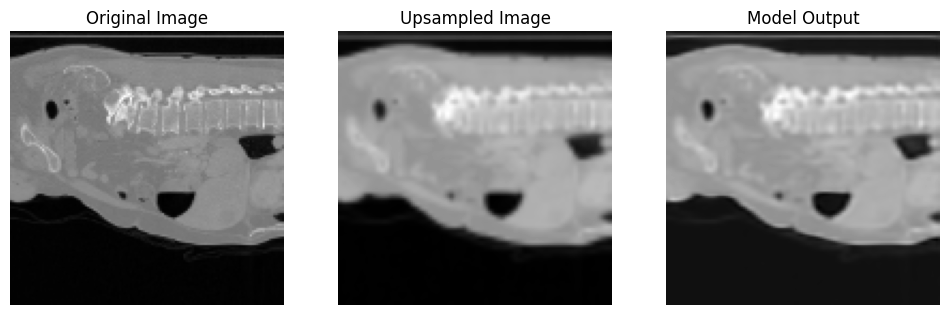

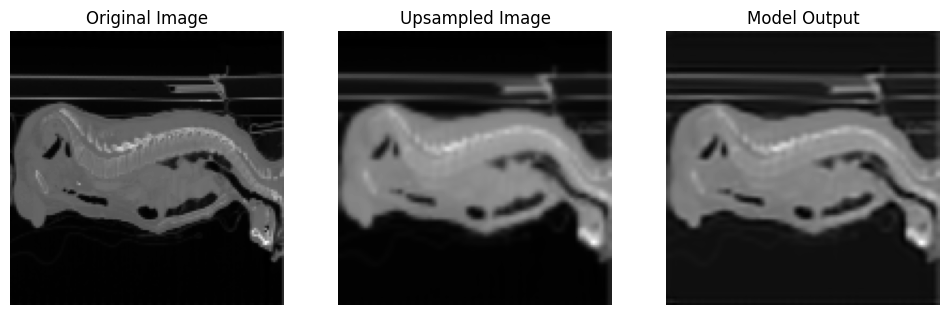

Validation - Epoch [10/100], SSIM: 0.9403, PSNR: 34.3830, MSE: 0.0003


Validation - Epoch [11/100], SSIM: 0.9504, PSNR: 32.9600, MSE: 0.0003


Validation - Epoch [12/100], SSIM: 0.9578, PSNR: 34.0288, MSE: 0.0004


Validation - Epoch [13/100], SSIM: 0.9456, PSNR: 32.8877, MSE: 0.0005


Validation - Epoch [14/100], SSIM: 0.9548, PSNR: 33.4098, MSE: 0.0003


Validation - Epoch [15/100], SSIM: 0.9532, PSNR: 35.8787, MSE: 0.0003


Validation - Epoch [16/100], SSIM: 0.9541, PSNR: 33.6017, MSE: 0.0004


Validation - Epoch [17/100], SSIM: 0.9571, PSNR: 35.2719, MSE: 0.0003


Validation - Epoch [18/100], SSIM: 0.9526, PSNR: 33.5986, MSE: 0.0004


Validation - Epoch [19/100], SSIM: 0.9522, PSNR: 34.2068, MSE: 0.0003


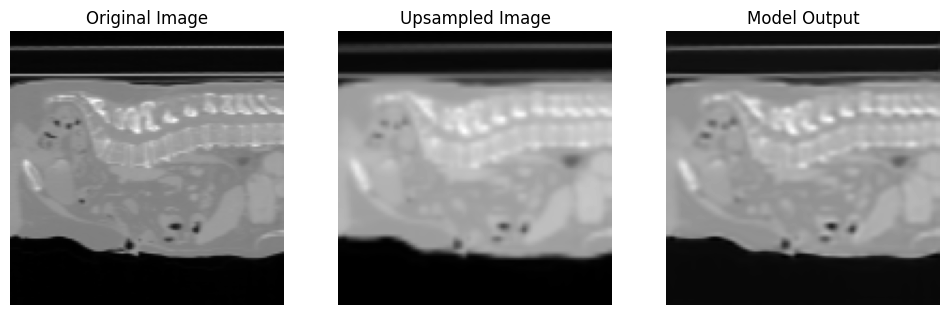

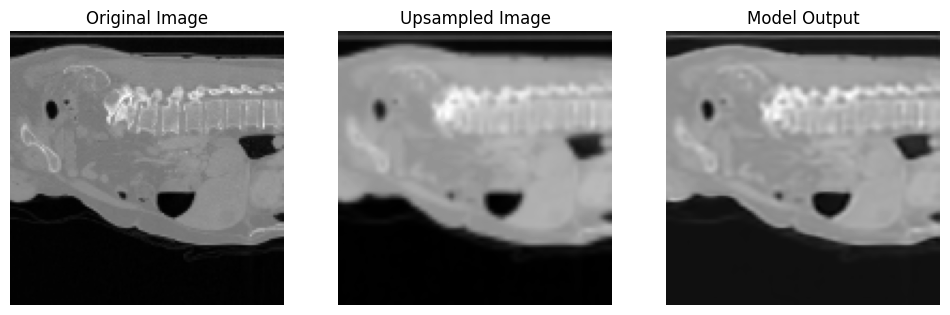

Validation - Epoch [20/100], SSIM: 0.9528, PSNR: 34.2757, MSE: 0.0003


Validation - Epoch [21/100], SSIM: 0.9505, PSNR: 34.5405, MSE: 0.0004


Validation - Epoch [22/100], SSIM: 0.9460, PSNR: 35.9523, MSE: 0.0002


Validation - Epoch [23/100], SSIM: 0.9565, PSNR: 35.4410, MSE: 0.0003


Validation - Epoch [24/100], SSIM: 0.9640, PSNR: 36.2091, MSE: 0.0002


Validation - Epoch [25/100], SSIM: 0.9574, PSNR: 35.4908, MSE: 0.0003


Validation - Epoch [26/100], SSIM: 0.9508, PSNR: 35.2284, MSE: 0.0003


Validation - Epoch [27/100], SSIM: 0.9505, PSNR: 35.3434, MSE: 0.0003


Validation - Epoch [28/100], SSIM: 0.9631, PSNR: 34.3694, MSE: 0.0003


Validation - Epoch [29/100], SSIM: 0.9600, PSNR: 34.7375, MSE: 0.0003


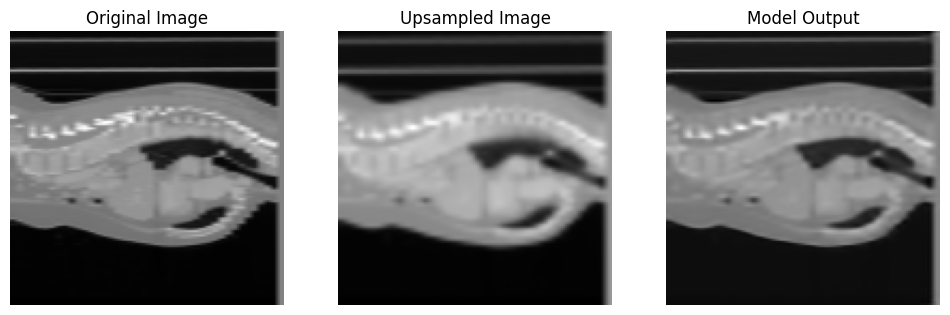

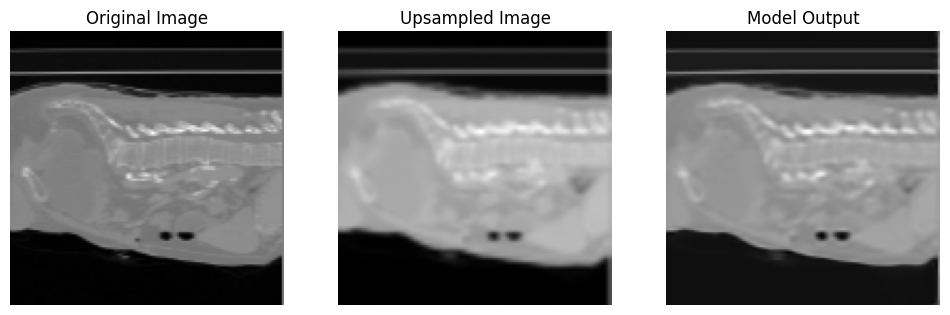

Validation - Epoch [30/100], SSIM: 0.9659, PSNR: 34.7655, MSE: 0.0003


Validation - Epoch [31/100], SSIM: 0.9557, PSNR: 34.7844, MSE: 0.0002


Validation - Epoch [32/100], SSIM: 0.9606, PSNR: 34.9757, MSE: 0.0003


Validation - Epoch [33/100], SSIM: 0.9638, PSNR: 35.7027, MSE: 0.0003


Validation - Epoch [34/100], SSIM: 0.9594, PSNR: 37.8380, MSE: 0.0002


Validation - Epoch [35/100], SSIM: 0.9485, PSNR: 33.6139, MSE: 0.0003


Validation - Epoch [36/100], SSIM: 0.9613, PSNR: 35.0916, MSE: 0.0003


Validation - Epoch [37/100], SSIM: 0.9696, PSNR: 35.6731, MSE: 0.0003


Validation - Epoch [38/100], SSIM: 0.9629, PSNR: 37.2342, MSE: 0.0002


Validation - Epoch [39/100], SSIM: 0.9571, PSNR: 37.6174, MSE: 0.0002


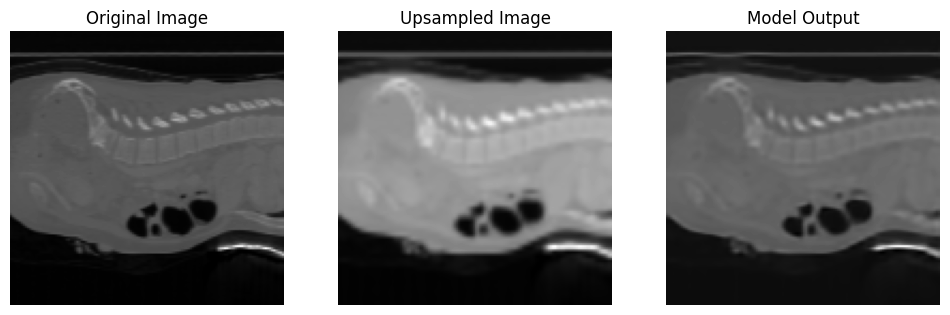

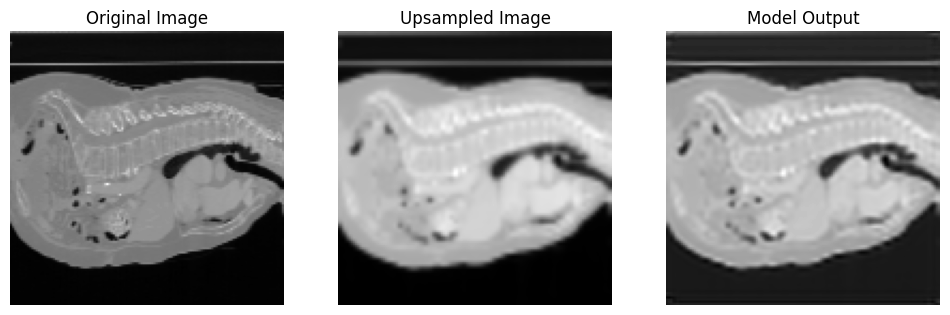

Validation - Epoch [40/100], SSIM: 0.9687, PSNR: 36.8167, MSE: 0.0002


Validation - Epoch [41/100], SSIM: 0.9641, PSNR: 36.2547, MSE: 0.0002


Validation - Epoch [42/100], SSIM: 0.9681, PSNR: 35.0778, MSE: 0.0003


Validation - Epoch [43/100], SSIM: 0.9486, PSNR: 35.2037, MSE: 0.0003


Validation - Epoch [44/100], SSIM: 0.9509, PSNR: 33.2145, MSE: 0.0005


Validation - Epoch [45/100], SSIM: 0.9659, PSNR: 35.8721, MSE: 0.0003


Validation - Epoch [46/100], SSIM: 0.9659, PSNR: 36.2108, MSE: 0.0002


Validation - Epoch [47/100], SSIM: 0.9691, PSNR: 35.1491, MSE: 0.0003


Validation - Epoch [48/100], SSIM: 0.9681, PSNR: 35.5385, MSE: 0.0003


Validation - Epoch [49/100], SSIM: 0.9516, PSNR: 35.5288, MSE: 0.0003


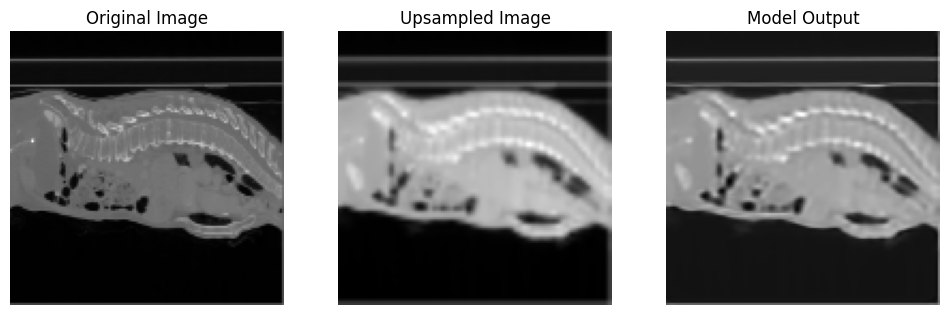

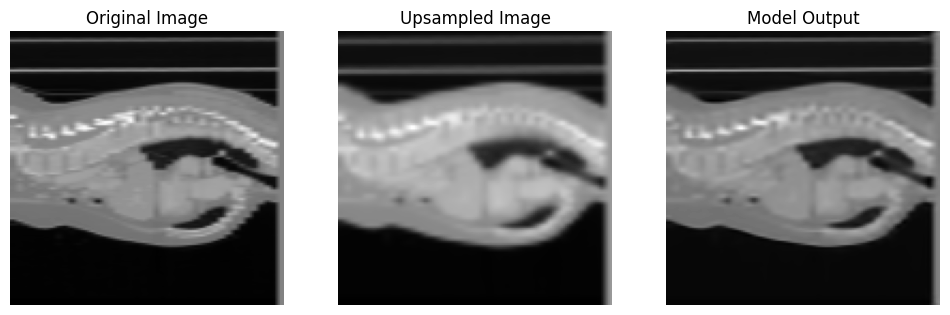

Validation - Epoch [50/100], SSIM: 0.9624, PSNR: 34.0552, MSE: 0.0003


Validation - Epoch [51/100], SSIM: 0.9539, PSNR: 33.8320, MSE: 0.0004


Validation - Epoch [52/100], SSIM: 0.9555, PSNR: 34.0678, MSE: 0.0004


Validation - Epoch [53/100], SSIM: 0.9489, PSNR: 34.6190, MSE: 0.0004


Validation - Epoch [54/100], SSIM: 0.9634, PSNR: 36.3907, MSE: 0.0002


Validation - Epoch [55/100], SSIM: 0.9574, PSNR: 36.0629, MSE: 0.0002


Validation - Epoch [56/100], SSIM: 0.9693, PSNR: 35.2047, MSE: 0.0003


Validation - Epoch [57/100], SSIM: 0.9597, PSNR: 33.9124, MSE: 0.0003


Validation - Epoch [58/100], SSIM: 0.9607, PSNR: 36.9159, MSE: 0.0002


Validation - Epoch [59/100], SSIM: 0.9478, PSNR: 33.4989, MSE: 0.0004


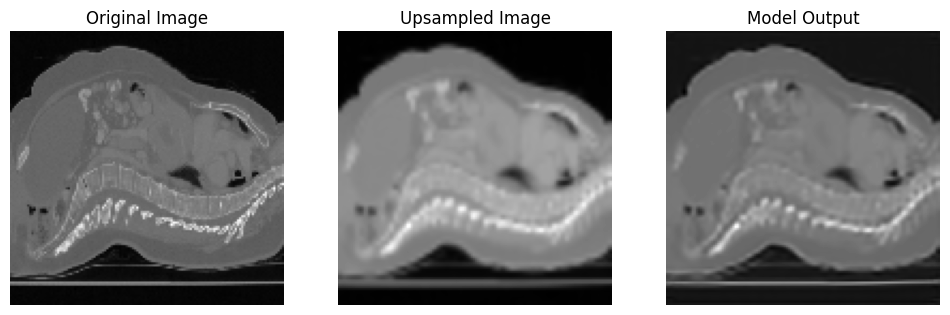

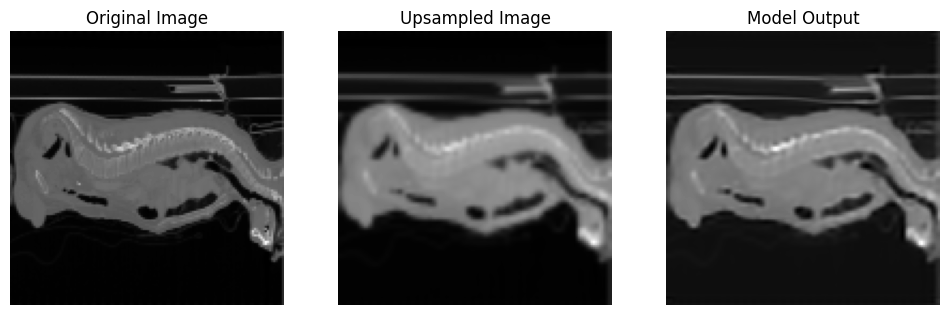

Validation - Epoch [60/100], SSIM: 0.9610, PSNR: 37.9889, MSE: 0.0002


Validation - Epoch [61/100], SSIM: 0.9681, PSNR: 35.7949, MSE: 0.0002


Validation - Epoch [62/100], SSIM: 0.9688, PSNR: 35.2747, MSE: 0.0003


Training:   8%|▊         | 3/40 [00:03<00:42,  1.14s/it]

In [ ]:
num_epochs = 100
scale_factor = 0.5
writer = SummaryWriter('runs/SRCNN3D_3')


for epoch in range(num_epochs):
    model.train()

    start_time = time.time()  

    for i, (low_res_inputs, high_res_targets) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        low_res_inputs = low_res_inputs.to(device)
        high_res_targets = high_res_targets.to(device)
        low_res_inputs = F.interpolate(low_res_inputs, size=high_res_targets.shape[2:], mode='trilinear', align_corners=False)
        outputs = model(low_res_inputs)
        loss = criterion(outputs, high_res_targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        writer.add_scalar('Loss/train', loss.item(), epoch * len(train_loader) + i)

    epoch_time = time.time() - start_time


    writer.add_scalar('Performance/Epoch Time (s)', epoch_time, epoch)

    model.eval()
    ssim_total, psnr_total, mse_total = 0, 0, 0
    selected_images = random.sample(range(len(val_loader.dataset)), k=2)

    with torch.no_grad():
        for idx in selected_images:
            low_res_input, high_res_target = val_loader.dataset[idx]
            low_res_input = low_res_input.unsqueeze(0).to(device)
            high_res_target = high_res_target.unsqueeze(0).to(device)
            
            low_res_input = F.interpolate(low_res_input, size=high_res_target.shape[2:], mode='trilinear', align_corners=False)
            outputs = model(low_res_input)
            ssim_val, psnr_val, mse_val = calculate_metrics(outputs, high_res_target)
            ssim_total += ssim_val
            psnr_total += psnr_val
            mse_total += mse_val

            if (epoch + 1) % 10 == 0:
                torch.save(model.state_dict(), f'model3/SRCNN3D_epoch_{epoch+1}.pth')
                visualize_images(high_res_target[0], low_res_input[0], outputs[0])



    avg_ssim = ssim_total / len(selected_images)
    avg_psnr = psnr_total / len(selected_images)
    avg_mse = mse_total / len(selected_images)
    writer.add_scalar('SSIM/val', avg_ssim, epoch)
    writer.add_scalar('PSNR/val', avg_psnr, epoch)
    writer.add_scalar('MSE/val', avg_mse, epoch)

    print(f'Validation - Epoch [{epoch + 1}/{num_epochs}], SSIM: {avg_ssim:.4f}, '
          f'PSNR: {avg_psnr:.4f}, MSE: {avg_mse:.4f}')
    
writer.close()


In [13]:
def test_model():
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Loop through a maximum of 20 test images
        for i, data in enumerate(test_loader):
            if i >= 20:
                break
            inputs = data.to(device)  # Move data to the appropriate device
            inputs_downsampled = F.interpolate(inputs, scale_factor=scale_factor, mode='trilinear', align_corners=False)
            # Upsample the inputs to match the model’s input requirements
            inputs_upsampled = F.interpolate(inputs_downsampled, size=inputs.shape[2:], mode='trilinear', align_corners=False)

            # Pass the upsampled input through the model to get super-resolved output
            outputs = model(inputs_upsampled)

            # Optionally, resize the output back to the original input size
            outputs_resized = F.interpolate(outputs, size=inputs.shape[2:], mode='trilinear', align_corners=False)

            # Visualize the original, upsampled, and model's output
            visualize_images(inputs[0], inputs_upsampled[0], outputs_resized[0])  # Updated to show resized output

test_model()


AttributeError: 'list' object has no attribute 'to'